In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense, Input
from tensorflow.keras.models import Sequential
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GRU, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Load the CSV file
data = pd.read_excel("modified_data.xlsx")  # Replace 'your_data.csv' with your file path
text_column = 'text'  # Replace 'text' with the name of the text column in your dataset
label_column = 'label'  # Replace 'label' with the name of the label column in your dataset


In [ ]:
data.head()

,question,answer,label
0,What is the most interesting scar you have?,I have a couple scars on my arm from an attemp...,1
1,What is the most interesting scar you have?,What is the story behind it? – 6/19\n\nThese a...,0
2,"Do you think Bruce Lee, if given the opportuni...",What the fuck man,1
3,"Do you think Bruce Lee, if given the opportuni...","If it were me, Bruce Lee would disembowel my p...",0
4,What was your Hamster’s “tragic death”?,Gonna be some gay shit in this thread....,1


In [ ]:
Q_A_columns = ['question', 'answer']

# Data preprocessing using NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Fill NaN values with empty strings in 'question' and 'answer' columns
data['question'].fillna('', inplace=True)
data['answer'].fillna('', inplace=True)

# Merge the question and answer columns into a single column
merged_column = data['question'] + ' ' + data['answer']

# Apply preprocessing function to the merged column
data['processed_text'] = merged_column.apply(preprocess_text)

In [ ]:
data['processed_text']

0        interesting scar couple scar arm attempted sui...
1                       interesting scar story behind scar
2        think bruce lee given opportunity fight would ...
3        think bruce lee given opportunity fight would ...
4              hamster tragic death gon na gay shit thread
                               ...                        
19995    whats goofiest uniformdress code youve wear de...
19996    instance wherein paused grateful alive able ex...
19997    instance wherein paused grateful alive able ex...
19998    movie portrayal santa claus put cage match dea...
19999    movie portrayal santa claus put cage match dea...
Name: processed_text, Length: 20000, dtype: object

In [ ]:
# Split data into train and test sets
X = data['question'].values + data['answer'].values
y = data[label_column].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 90  # Adjust as needed
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [ ]:
# Load BERT model and tokenizer
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Prepare BERT input
def prepare_bert_input(texts):
    return tokenizer_bert('processed_text', padding=True, truncation=True, return_tensors="pt")

X_train_bert = prepare_bert_input(X_train)
X_test_bert = prepare_bert_input(X_test)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force TensorFlow to use CPU onlyimport tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GRU
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input

# Build CNN model
model = Sequential()
cnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build ANN model
ann_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build RNN Model
rnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    SimpleRNN(100),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    LSTM(128),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    Bidirectional(LSTM(128)),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build  GRU Model
gru_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    GRU(128),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Build Bidirectional RNN model
birnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    Bidirectional(SimpleRNN(128)),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
# Compile models
from tensorflow.keras.optimizers import Adam  # Import the Adam optimizer if not already imported
optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
birnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


CNN Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 42s 113ms/step - loss: 0.5442 - accuracy: 0.7278 - val_loss: 0.5110 - val_accuracy: 0.7610
Epoch 2/10
360/360 [==============================] - 38s 106ms/step - loss: 0.3056 - accuracy: 0.8744 - val_loss: 0.5563 - val_accuracy: 0.7597
Epoch 3/10
360/360 [==============================] - 39s 108ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.9407 - val_accuracy: 0.7209
Epoch 4/10
360/360 [==============================] - 38s 105ms/step - loss: 0.0045 - accuracy: 0.9996 - val_loss: 0.9716 - val_accuracy: 0.7495
Epoch 5/10
360/360 [==============================] - 27s 75ms/step - loss: 4.7921e-04 - accuracy: 1.0000 - val_loss: 1.0322 - val_accuracy: 0.7496
Epoch 6/10
360/360 [==============================] - 29s 80ms/step - loss: 2.1156e-04 - accuracy: 1.0000 - val_loss: 1.0777 - val_accuracy: 0.7513
Epoch 7/10
360/360 [==============================] - 28s 77ms/step - loss: 1.3446e-04 - accuracy: 1.0

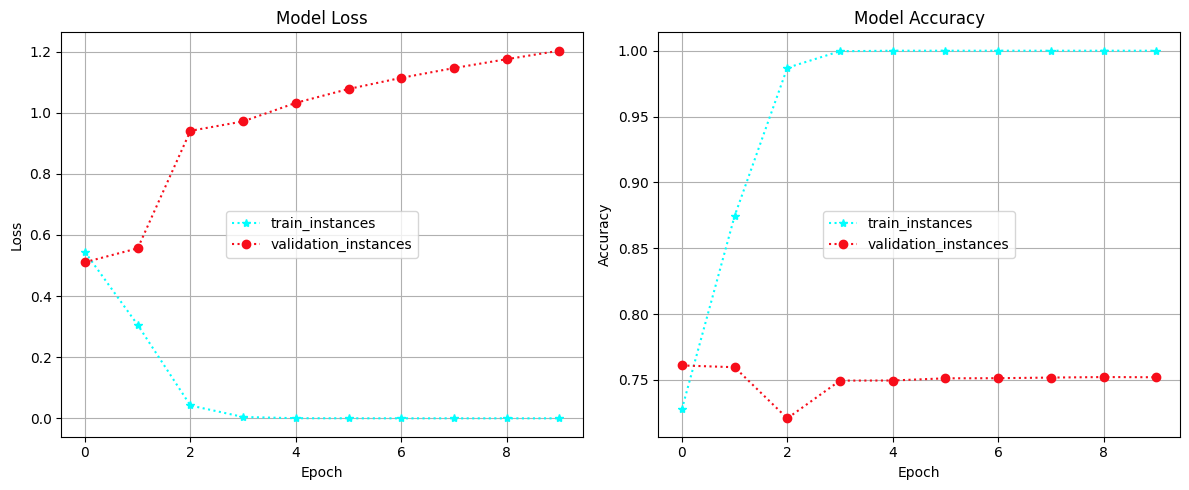

In [ ]:
import matplotlib.pyplot as plt
from keras.callbacks import Callback

# Define the modified PlotLosses callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

    def on_train_end(self, logs={}):
        # Create a single row of subplots for both loss and accuracy

        # Model Loss and Accuracy Subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        # Model Loss
        axes[0].plot(self.losses, marker='*', color='cyan', linestyle=':')
        axes[0].plot(self.val_losses, marker='o', color='#f70d1a', linestyle=':')
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['train_instances', 'validation_instances'], loc='center')
        axes[0].grid(which='both')  # Set 'which' parameter to 'both' for both major and minor grid lines

        # Model Accuracy
        axes[1].plot(self.acc, marker='*', color='cyan', linestyle=':')
        axes[1].plot(self.val_acc, marker='o', color='#f70d1a', linestyle=':')
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['train_instances', 'validation_instances'], loc='center')
        axes[1].grid(which='both')  # Set 'which' parameter to 'both' for both major and minor grid lines

        plt.tight_layout()
        plt.show()

# Create an instance of the custom callback
plot_losses = PlotLosses()

# Train your BiRNN model and pass the callback
num_epochs = 10  # Adjust as needed
batch_size = 15  # Adjust as needed
validation_split = 0.7  # Adjust as needed

print("CNN Loss and Accuracy")
hist = cnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


ANN Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 26s 71ms/step - loss: 0.5346 - accuracy: 0.7276 - val_loss: 0.4640 - val_accuracy: 0.7783
Epoch 2/10
360/360 [==============================] - 24s 67ms/step - loss: 0.1580 - accuracy: 0.9461 - val_loss: 0.5563 - val_accuracy: 0.7694
Epoch 3/10
360/360 [==============================] - 24s 66ms/step - loss: 0.0084 - accuracy: 0.9994 - val_loss: 0.6540 - val_accuracy: 0.7682
Epoch 4/10
360/360 [==============================] - 24s 68ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.6853 - val_accuracy: 0.7703
Epoch 5/10
360/360 [==============================] - 24s 66ms/step - loss: 4.0626e-04 - accuracy: 1.0000 - val_loss: 0.7215 - val_accuracy: 0.7726
Epoch 6/10
360/360 [==============================] - 24s 65ms/step - loss: 2.1679e-04 - accuracy: 1.0000 - val_loss: 0.7495 - val_accuracy: 0.7729
Epoch 7/10
360/360 [==============================] - 24s 67ms/step - loss: 1.3453e-04 - accuracy: 1.0000 

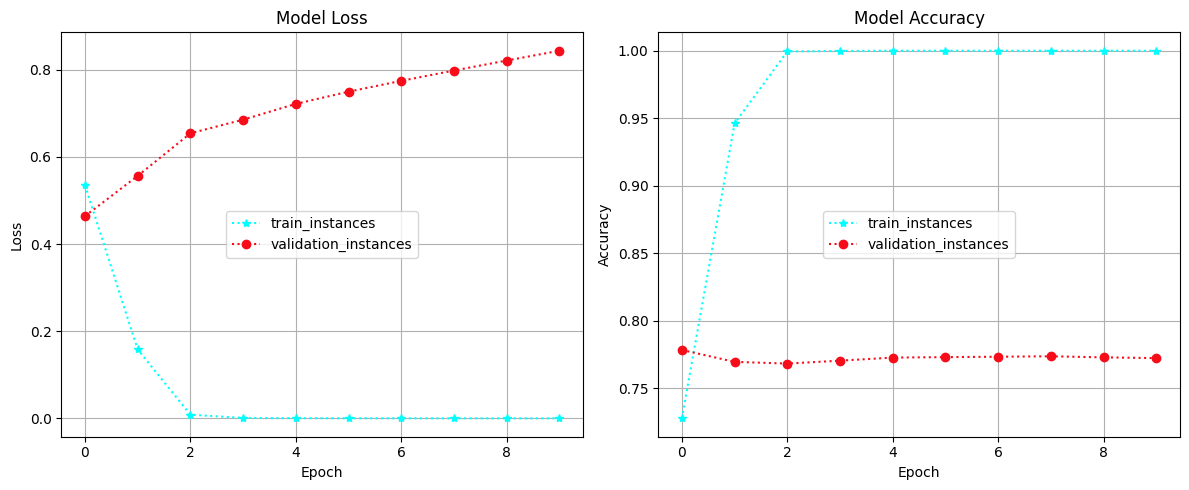

In [ ]:
print("ANN Loss and Accuracy")
hist = ann_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


RNN Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 38s 101ms/step - loss: 0.6515 - accuracy: 0.6089 - val_loss: 0.6228 - val_accuracy: 0.6490
Epoch 2/10
360/360 [==============================] - 31s 85ms/step - loss: 0.2358 - accuracy: 0.9144 - val_loss: 0.7021 - val_accuracy: 0.6643
Epoch 3/10
360/360 [==============================] - 36s 99ms/step - loss: 0.0187 - accuracy: 0.9957 - val_loss: 0.8810 - val_accuracy: 0.6733
Epoch 4/10
360/360 [==============================] - 31s 86ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.9216 - val_accuracy: 0.6889
Epoch 5/10
360/360 [==============================] - 31s 87ms/step - loss: 5.1970e-04 - accuracy: 1.0000 - val_loss: 0.9539 - val_accuracy: 0.6922
Epoch 6/10
360/360 [==============================] - 36s 99ms/step - loss: 2.8707e-04 - accuracy: 1.0000 - val_loss: 0.9960 - val_accuracy: 0.6914
Epoch 7/10
360/360 [==============================] - 31s 85ms/step - loss: 1.8457e-04 - accuracy: 1.0000

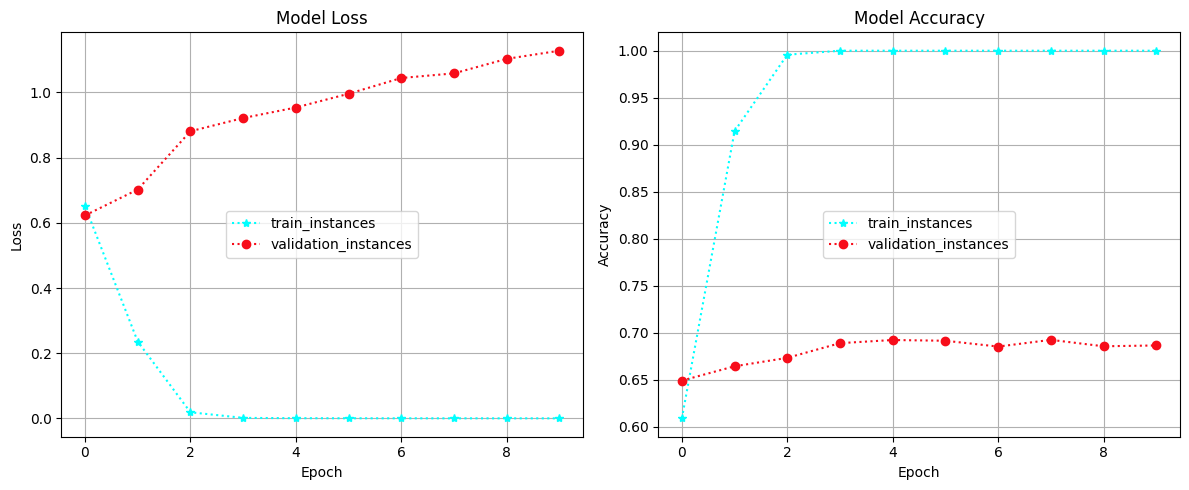

In [ ]:
print("RNN Loss and Accuracy")
hist = rnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


LSTM Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 69s 183ms/step - loss: 0.5579 - accuracy: 0.7161 - val_loss: 0.4827 - val_accuracy: 0.7744
Epoch 2/10
360/360 [==============================] - 83s 231ms/step - loss: 0.3134 - accuracy: 0.8735 - val_loss: 0.5444 - val_accuracy: 0.7541
Epoch 3/10
360/360 [==============================] - 83s 231ms/step - loss: 0.0942 - accuracy: 0.9656 - val_loss: 0.7535 - val_accuracy: 0.7326
Epoch 4/10
360/360 [==============================] - 86s 239ms/step - loss: 0.0358 - accuracy: 0.9874 - val_loss: 1.0614 - val_accuracy: 0.7006
Epoch 5/10
360/360 [==============================] - 84s 233ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 1.3150 - val_accuracy: 0.7147
Epoch 6/10
360/360 [==============================] - 84s 234ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 1.6269 - val_accuracy: 0.7075
Epoch 7/10
360/360 [==============================] - 83s 230ms/step - loss: 0.0116 - accuracy: 0.9967 - va

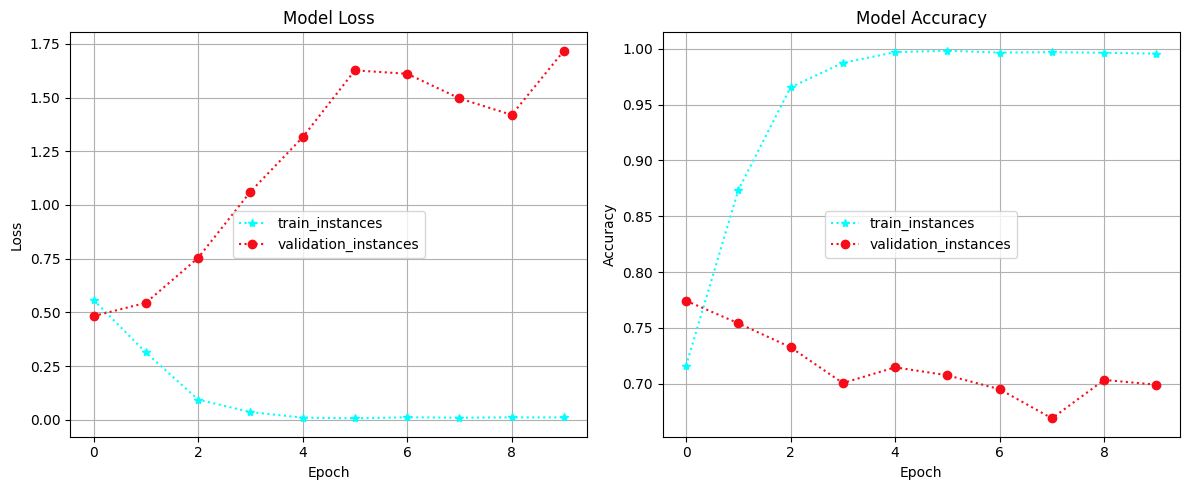

In [ ]:
print("LSTM Loss and Accuracy")
hist = lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


BiLSTM Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 115s 310ms/step - loss: 0.5570 - accuracy: 0.7189 - val_loss: 0.5135 - val_accuracy: 0.7559
Epoch 2/10
360/360 [==============================] - 106s 294ms/step - loss: 0.3160 - accuracy: 0.8700 - val_loss: 0.5463 - val_accuracy: 0.7515
Epoch 3/10
360/360 [==============================] - 107s 296ms/step - loss: 0.1027 - accuracy: 0.9661 - val_loss: 0.9505 - val_accuracy: 0.6771
Epoch 4/10
360/360 [==============================] - 107s 296ms/step - loss: 0.0487 - accuracy: 0.9833 - val_loss: 0.9070 - val_accuracy: 0.7013
Epoch 5/10
360/360 [==============================] - 105s 293ms/step - loss: 0.0248 - accuracy: 0.9920 - val_loss: 1.1863 - val_accuracy: 0.7068
Epoch 6/10
360/360 [==============================] - 106s 295ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 1.4723 - val_accuracy: 0.7143
Epoch 7/10
360/360 [==============================] - 106s 296ms/step - loss: 0.0028 - accuracy: 0.

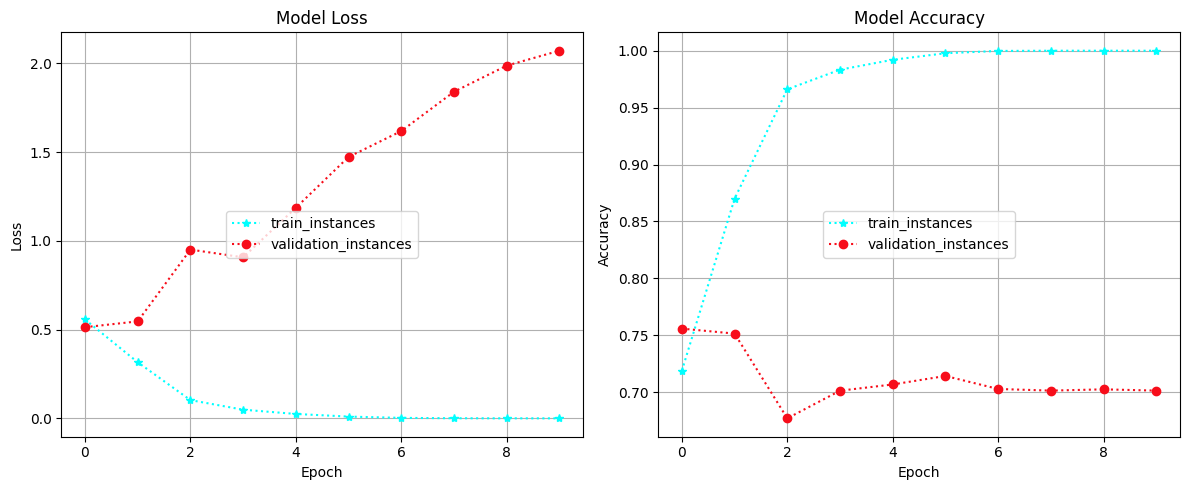

In [ ]:
print("BiLSTM Loss and Accuracy")
hist = bilstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


GRU Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 60s 160ms/step - loss: 0.6094 - accuracy: 0.6491 - val_loss: 0.5349 - val_accuracy: 0.7260
Epoch 2/10
360/360 [==============================] - 54s 150ms/step - loss: 0.2817 - accuracy: 0.8859 - val_loss: 0.5426 - val_accuracy: 0.7470
Epoch 3/10
360/360 [==============================] - 53s 147ms/step - loss: 0.0679 - accuracy: 0.9785 - val_loss: 0.7997 - val_accuracy: 0.6975
Epoch 4/10
360/360 [==============================] - 53s 148ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 1.2618 - val_accuracy: 0.7071
Epoch 5/10
360/360 [==============================] - 56s 157ms/step - loss: 0.0098 - accuracy: 0.9963 - val_loss: 1.2738 - val_accuracy: 0.7056
Epoch 6/10
360/360 [==============================] - 57s 160ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.3847 - val_accuracy: 0.7077
Epoch 7/10
360/360 [==============================] - 54s 151ms/step - loss: 0.0103 - accuracy: 0.9967 - val

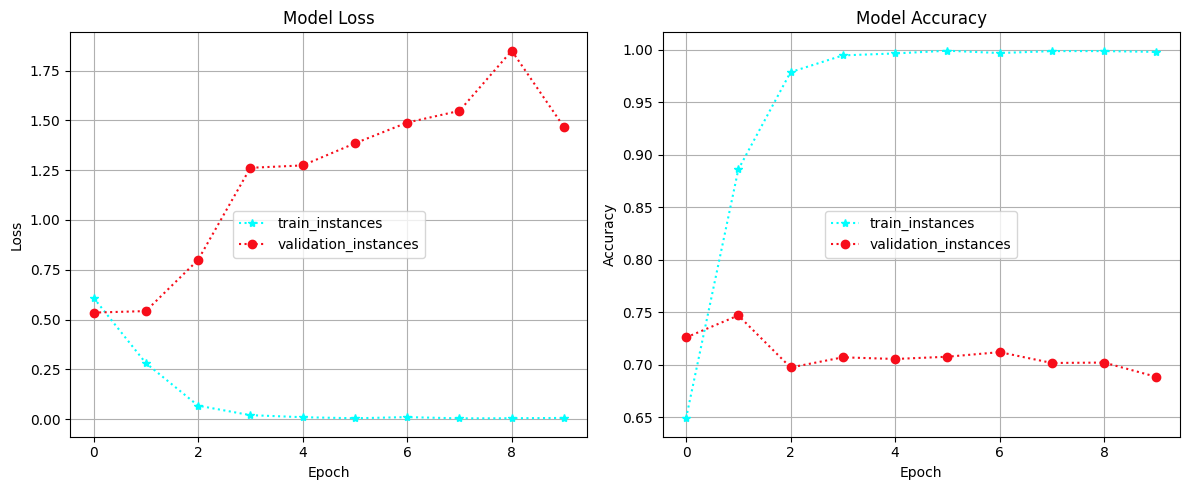

In [ ]:
# Assuming you're using the Adam optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the optimizer for the model
gru_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Then proceed with training
print("GRU Loss and Accuracy")
hist = gru_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


BiRNN Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 45s 117ms/step - loss: 0.7046 - accuracy: 0.5500 - val_loss: 0.6596 - val_accuracy: 0.5880
Epoch 2/10
360/360 [==============================] - 42s 117ms/step - loss: 0.5085 - accuracy: 0.7661 - val_loss: 0.6786 - val_accuracy: 0.6275
Epoch 3/10
360/360 [==============================] - 42s 117ms/step - loss: 0.1771 - accuracy: 0.9293 - val_loss: 0.8908 - val_accuracy: 0.6110
Epoch 4/10
360/360 [==============================] - 41s 115ms/step - loss: 0.0319 - accuracy: 0.9906 - val_loss: 1.1469 - val_accuracy: 0.6019
Epoch 5/10
360/360 [==============================] - 41s 115ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 1.4626 - val_accuracy: 0.5887
Epoch 6/10
360/360 [==============================] - 43s 121ms/step - loss: 8.0088e-04 - accuracy: 1.0000 - val_loss: 1.5338 - val_accuracy: 0.5876
Epoch 7/10
360/360 [==============================] - 42s 116ms/step - loss: 2.9601e-04 - accuracy: 1.

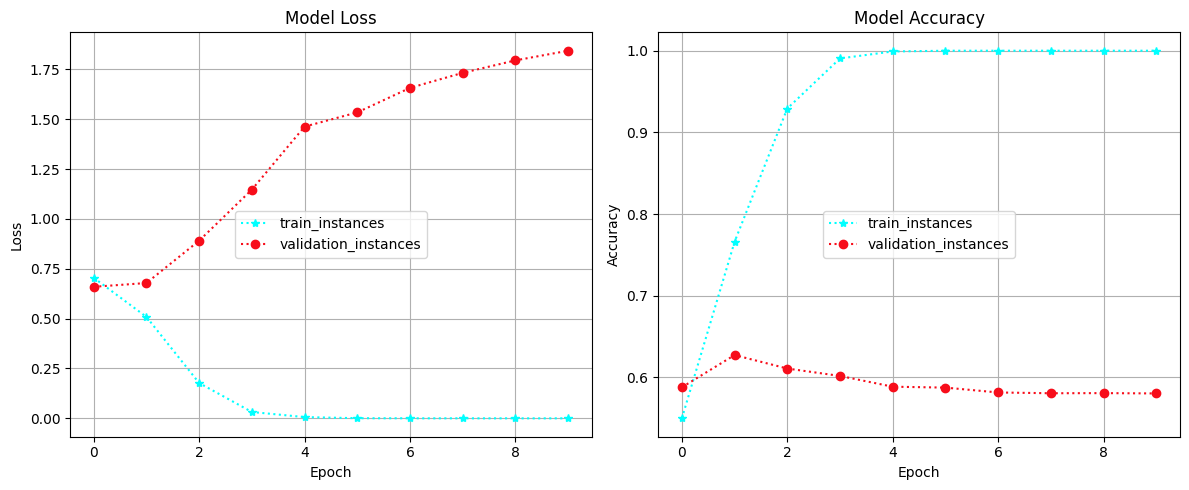

In [ ]:
print("BiRNN Loss and Accuracy")
hist = birnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


Epoch 1/5
450/450 [==============================] - 52s 110ms/step - loss: 0.5274 - accuracy: 0.7344 - val_loss: 0.4599 - val_accuracy: 0.7842
Epoch 2/5
450/450 [==============================] - 47s 105ms/step - loss: 0.2099 - accuracy: 0.9191 - val_loss: 0.5608 - val_accuracy: 0.7678
Epoch 3/5
450/450 [==============================] - 47s 103ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.6994 - val_accuracy: 0.7622
Epoch 4/5
450/450 [==============================] - 47s 105ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.9133 - val_accuracy: 0.7581
Epoch 5/5
450/450 [==============================] - 47s 105ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.9168 - val_accuracy: 0.7336
BiRNN Loss and Accuracy
Epoch 1/10
360/360 [==============================] - 44s 118ms/step - loss: 0.2427 - accuracy: 0.9024 - val_loss: 0.3510 - val_accuracy: 0.8787
Epoch 2/10
360/360 [==============================] - 42s 115ms/step - loss: 0.0365 - accuracy: 0.9861 - val_lo

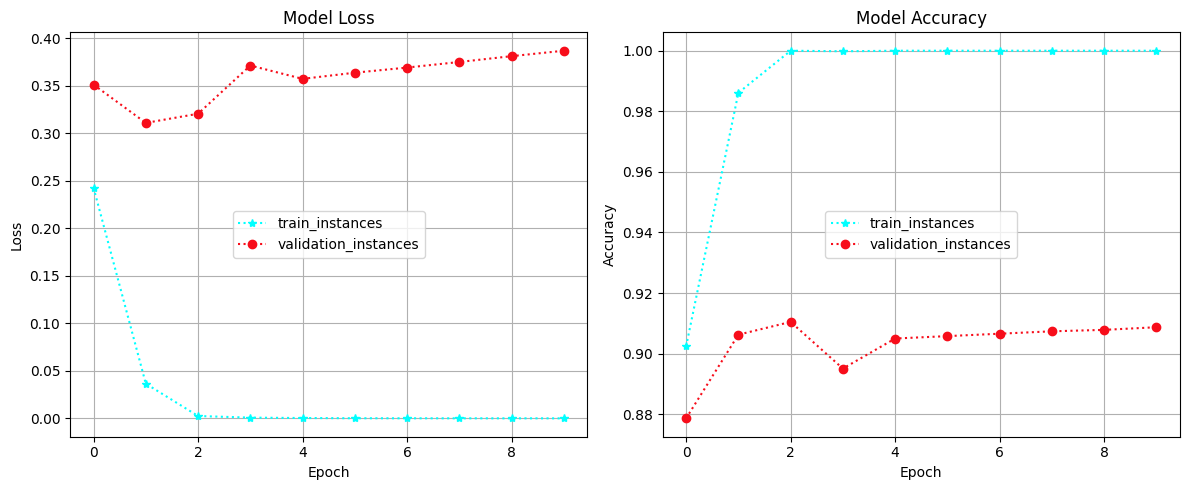

In [ ]:
# Build Bidirectional RNN model
birnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    Bidirectional(SimpleRNN(128)),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the Bidirectional RNN model
birnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the Bidirectional RNN model
birnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)




import matplotlib.pyplot as plt
from keras.callbacks import Callback

# Define the modified PlotLosses callback
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

    def on_train_end(self, logs={}):
        # Create a single row of subplots for both loss and accuracy

        # Model Loss and Accuracy Subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        # Model Loss
        axes[0].plot(self.losses, marker='*', color='cyan', linestyle=':')
        axes[0].plot(self.val_losses, marker='o', color='#f70d1a', linestyle=':')
        axes[0].set_title('Model Loss')
        axes[0].set_ylabel('Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['train_instances', 'validation_instances'], loc='center')
        axes[0].grid(which='both')  # Set 'which' parameter to 'both' for both major and minor grid lines

        # Model Accuracy
        axes[1].plot(self.acc, marker='*', color='cyan', linestyle=':')
        axes[1].plot(self.val_acc, marker='o', color='#f70d1a', linestyle=':')
        axes[1].set_title('Model Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['train_instances', 'validation_instances'], loc='center')
        axes[1].grid(which='both')  # Set 'which' parameter to 'both' for both major and minor grid lines

        plt.tight_layout()
        plt.show()

# Create an instance of the custom callback
plot_losses = PlotLosses()

# Train your BiRNN model and pass the callback
num_epochs = 10  # Adjust as needed
batch_size = 15  # Adjust as needed
validation_split = 0.7  # Adjust as needed

print("BiRNN Loss and Accuracy")
hist = birnn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[plot_losses])


In [ ]:
# Evaluate models
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
ann_loss, ann_accuracy = ann_model.evaluate(X_test, y_test)
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test)
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
gru_loss, gru_accuracy = gru_model.evaluate(X_test, y_test)
bilstm_loss, bilstm_accuracy = bilstm_model.evaluate(X_test, y_test)
birnn_loss, birnn_accuracy = birnn_model.evaluate(X_test, y_test)

print(f"CNN Model Accuracy: {cnn_accuracy}")
print(f"ANN Model Accuracy: {ann_accuracy}")
print(f"RNN Model Accuracy: {rnn_accuracy}")
print(f"LSTM Model Accuracy: {lstm_accuracy}")
print(f"BiLSTM Model Accuracy: {bilstm_accuracy}")
print(f"GRU Model Accuracy: {gru_accuracy}")
print(f"BiRNN Model Accuracy: {birnn_accuracy}")



63/63 [==============================] - 1s 16ms/step - loss: 1.3399 - accuracy: 0.7095
CNN Model Accuracy: 0.7325000166893005
ANN Model Accuracy: 0.7505000233650208
RNN Model Accuracy: 0.6654999852180481
LSTM Model Accuracy: 0.6744999885559082
BiLSTM Model Accuracy: 0.6725000143051147
GRU Model Accuracy: 0.6769999861717224
BiRNN Model Accuracy: 0.7095000147819519


In [ ]:
# Evaluate models
birnn_loss, birnn_accuracy = birnn_model.evaluate(X_test, y_test)
print(f"BiRNN Model Accuracy: {birnn_accuracy}")

63/63 [==============================] - 1s 16ms/step - loss: 1.3399 - accuracy: 0.7095
BiRNN Model Accuracy: 0.7095000147819519


In [ ]:
#Model classification_report (CNN)
from sklearn.metrics import confusion_matrix, classification_report
# Get the predicted classes
cnn_predictions = cnn_model.predict(X_test)  # X_test contains your test data
cnn_predicted_classes = cnn_predictions.argmax(axis=-1)
cnn_true_classes = y_test #these are true labels for your test data
cnn_classification_report = classification_report(cnn_true_classes, cnn_predicted_classes)

#Model the classification report
print("CNN Classification Report:")
print(cnn_classification_report)
print("========================================================")
print("\n\n")

#Model classification_report (ANN)
# Get the predicted classes
ann_predictions = ann_model.predict(X_test)  # X_test contains your test data
ann_predicted_classes = ann_predictions.argmax(axis=-1)
ann_true_classes = y_test #these are true labels for your test data
ann_classification_report = classification_report(ann_true_classes, ann_predicted_classes)

# Print the classification report
print("ANN Classification Report:")
print(ann_classification_report)
print("========================================================")
print("\n\n")

#Model classification_report (RNN)
# Get the predicted classes
rnn_predictions = rnn_model.predict(X_test)  # X_test contains your test data
rnn_predicted_classes = rnn_predictions.argmax(axis=-1)
rnn_true_classes = y_test #these are true labels for your test data
rnn_classification_report = classification_report(rnn_true_classes, rnn_predicted_classes)

# Print the classification report
print("RNN Classification Report:")
print(rnn_classification_report)
print("========================================================")
print("\n\n")

#Model classification_report (LSTM)
# Get the predicted classes
lstm_predictions = lstm_model.predict(X_test)  # X_test contains your test data
lstm_predicted_classes = lstm_predictions.argmax(axis=-1)
lstm_true_classes = y_test #these are true labels for your test data
lstm_classification_report = classification_report(lstm_true_classes, lstm_predicted_classes)

# Print the classification report
print("LSTM Classification Report:")
print(lstm_classification_report)
print("========================================================")
print("\n\n")

#Model classification_report (GRU (Gated Recurrent Unit))
# Get the predicted classes
gru_predictions = lstm_model.predict(X_test)  # X_test contains your test data
gru_predicted_classes = gru_predictions.argmax(axis=-1)
gru_true_classes = y_test #these are true labels for your test data
gru_classification_report = classification_report(gru_true_classes, gru_predicted_classes)

# Print the classification report
print("GRU (Gated Recurrent Unit)Classification Report:")
print(gru_classification_report)
print("========================================================")
print("\n\n")


63/63 [==============================] - 1s 9ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1003
           1       0.73      0.73      0.73       997

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000




63/63 [==============================] - 0s 4ms/step
ANN Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1003
           1       0.76      0.74      0.75       997

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000




63/63 [==============================] - 1s 9ms/step
RNN Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.64      0.66  

In [ ]:
#Model the classification report
#Model classification_report (BiRNN)
# Get the predicted classes

bilstm_predictions = bilstm_model.predict(X_test)  # X_test contains your test data
bilstm_predicted_classes = bilstm_predictions.argmax(axis=-1)
bilstm_true_classes = y_test #these are true labels for your test data
bilstm_classification_report = classification_report(bilstm_true_classes, bilstm_predicted_classes)

print("BiLSTM Classification Report:")
print(bilstm_classification_report)
print("========================================================")
print("\n\n")

63/63 [==============================] - 8s 110ms/step
BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      1003
           1       0.67      0.66      0.67       997

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000






In [ ]:
#Model the classification report
#Model classification_report (BiRNN)
# Get the predicted classes

birnn_predictions = birnn_model.predict(X_test)  # X_test contains your test data
birnn_predicted_classes = birnn_predictions.argmax(axis=-1)
birnn_true_classes = y_test #these are true labels for your test data
birnn_classification_report = classification_report(birnn_true_classes, birnn_predicted_classes)

print("BiRNN Classification Report:")
print(birnn_classification_report)
print("========================================================")
print("\n\n")



63/63 [==============================] - 1s 16ms/step
BiRNN Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      1003
           1       0.71      0.71      0.71       997

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.71      2000






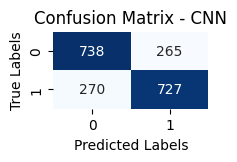

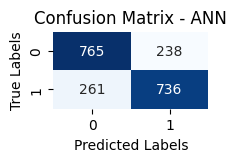

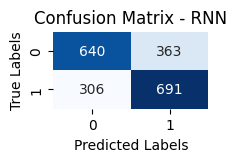

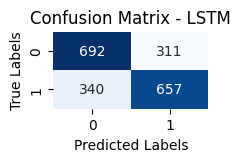

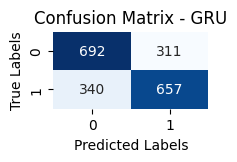

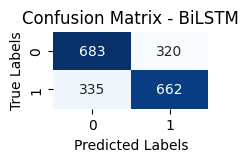

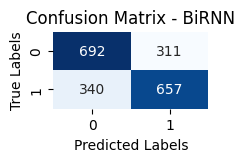

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model_name, true_classes, predicted_classes):
    # Calculate the confusion matrix
    confusion = confusion_matrix(true_classes, predicted_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(2, 1))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Model classification_report (CNN)
# ... (Previous code for CNN classification report)

# Plot confusion matrix for CNN
plot_confusion_matrix("CNN", cnn_true_classes, cnn_predicted_classes)
plot_confusion_matrix("ANN", ann_true_classes, ann_predicted_classes)
plot_confusion_matrix("RNN", rnn_true_classes, rnn_predicted_classes)
plot_confusion_matrix("LSTM", lstm_true_classes, lstm_predicted_classes)
plot_confusion_matrix("GRU", gru_true_classes, gru_predicted_classes)
plot_confusion_matrix("BiLSTM", bilstm_true_classes, bilstm_predicted_classes)
plot_confusion_matrix("BiRNN", gru_true_classes, gru_predicted_classes)

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Calculate the predicted probabilities for each model

# Model classification_report (CNN)
cnn_predictions = cnn_model.predict(X_test)  # X_test contains your test data
cnn_predicted_probs = cnn_predictions[:, 1]  # Assuming you're interested in class 1

# Model classification_report (ANN)
ann_predictions = ann_model.predict(X_test)  # X_test contains your test data
ann_predicted_probs = ann_predictions[:, 1]  # Assuming you're interested in class 1

# Model classification_report (RNN)
rnn_predictions = rnn_model.predict(X_test)  # X_test contains your test data
rnn_predicted_probs = rnn_predictions[:, 1]  # Assuming you're interested in class 1

# Model classification_report (LSTM)
lstm_predictions = lstm_model.predict(X_test)  # X_test contains your test data
lstm_predicted_probs = lstm_predictions[:, 1]  # Assuming you're interested in class 1

# Model classification_report (GRU (Gated Recurrent Unit))
gru_predictions = gru_model.predict(X_test)  # X_test contains your test data
gru_predicted_probs = gru_predictions[:, 1]  # Assuming you're interested in class 1

# Convert y_test to binary labels (0 or 1) assuming it's one-hot encoded
y_test_binary = np.argmax(y_test, axis=1)

# Reshape y_test to a 2D array with a single column
y_test = y_test.reshape(-1, 1)

# Calculate ROC curves and AUC scores
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_binary, cnn_predicted_probs)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_ann, tpr_ann, _ = roc_curve(y_test_binary, ann_predicted_probs)
roc_auc_ann = auc(fpr_ann, tpr_ann)

fpr_rnn, tpr_rnn, _ = roc_curve(y_test_binary, rnn_predicted_probs)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

fpr_lstm, tpr_lstm, _ = roc_curve(y_test_binary, lstm_predicted_probs)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_test_binary, gru_predicted_probs)
roc_auc_gru = auc(fpr_gru, tpr_gru)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label=f'ROC CNN (AUC = {roc_auc_cnn:.2f})')
plt.plot(fpr_ann, tpr_ann, color='red', lw=2, label=f'ROC ANN (AUC = {roc_auc_ann:.2f})')
plt.plot(fpr_rnn, tpr_rnn, color='blue', lw=2, label=f'ROC RNN (AUC = {roc_auc_rnn:.2f})')
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label=f'ROC LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, color='purple', lw=2, label=f'ROC GRU (AUC = {roc_auc_gru:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


63/63 [==============================] - 2s 22ms/step


AxisError: axis 1 is out of bounds for array of dimension 1

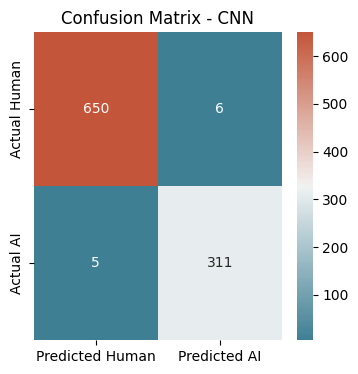

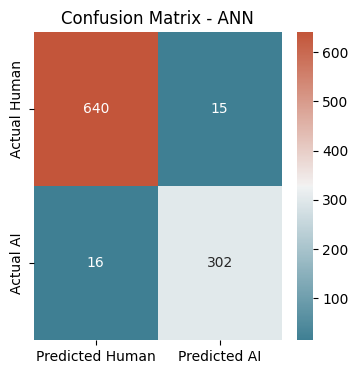

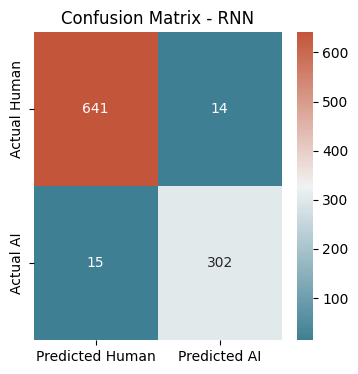

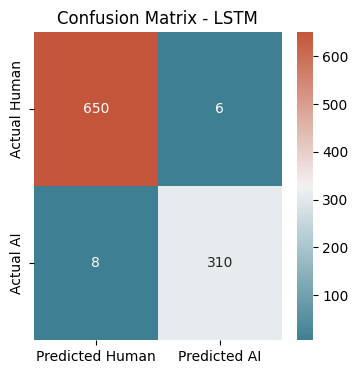

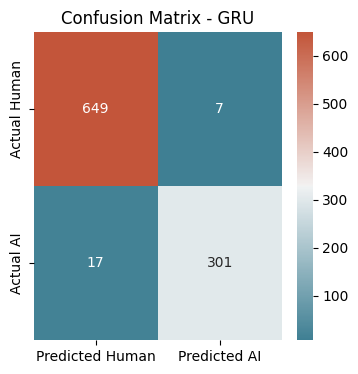

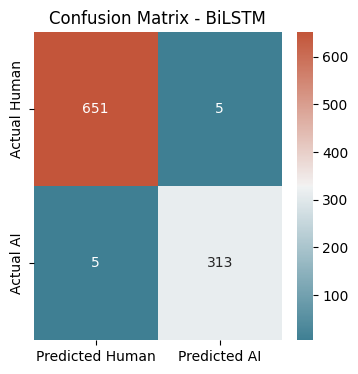

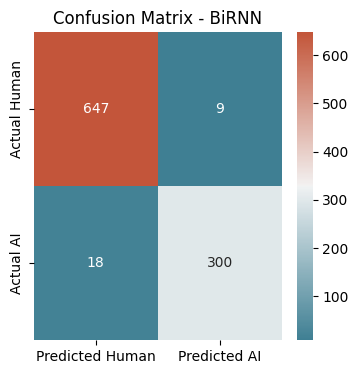

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the data
models = ['CNN', 'ANN', 'RNN', 'LSTM', 'GRU', 'BiLSTM', 'BiRNN']
true_positives = np.array([650, 640, 641, 650, 649, 651, 647])
false_positives = np.array([6, 15, 14, 6, 7, 5, 9])
true_negatives = np.array([311, 302, 302, 310, 301, 313, 300])
false_negatives = np.array([5, 16, 15, 8, 17, 5, 18])

# Create confusion matrices
confusion_matrices = [np.array([[tp, fp], [fn, tn]]) for tp, fp, tn, fn in zip(true_positives, false_positives, true_negatives, false_negatives)]

# Define a custom color map that blends blue and yellow
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot confusion matrices for each model with the custom color map
for i, model in enumerate(models):
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap=cmap, xticklabels=['Predicted Human', 'Predicted AI'], yticklabels=['Actual Human', 'Actual AI'])
    plt.title(f'Confusion Matrix - {model}')
    plt.show()


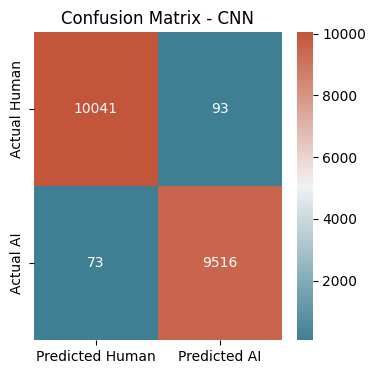

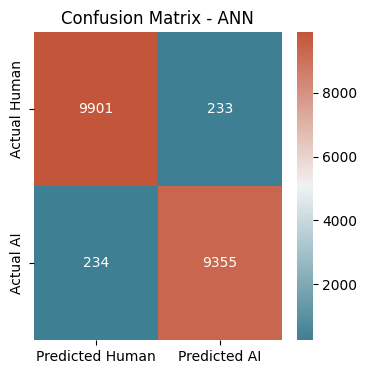

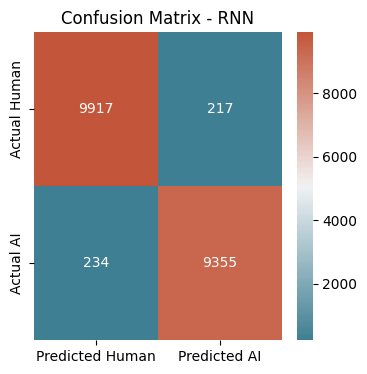

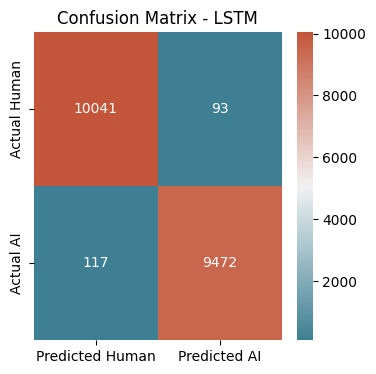

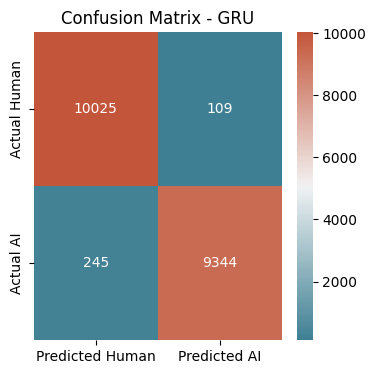

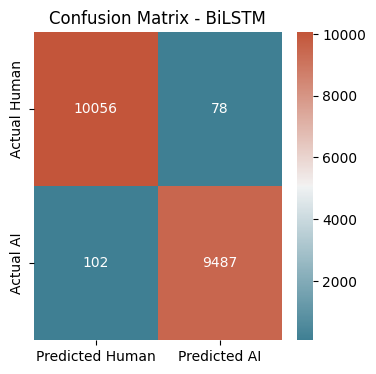

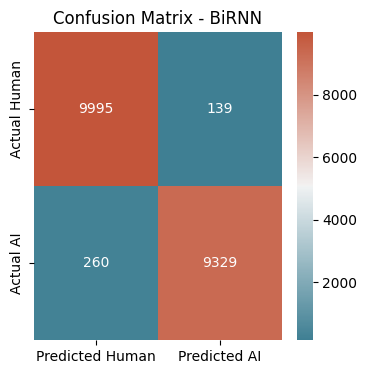

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
models = ['CNN', 'ANN', 'RNN', 'LSTM', 'GRU', 'BiLSTM', 'BiRNN']
true_positives = np.array([10041, 9901, 9917, 10041, 10025, 10056, 9995])
false_positives = np.array([93, 233, 217, 93, 109, 78, 139])
true_negatives = np.array([73, 234, 234, 117, 245, 102, 260])
false_negatives = np.array([9516, 9355, 9355, 9472, 9344, 9487, 9329])

# Create confusion matrices
confusion_matrices = [np.array([[tp, fp], [fn, tn]]) for tp, fp, fn, tn in zip(true_positives, false_positives, true_negatives, false_negatives)]

# Define a custom color map that blends blue and yellow
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot confusion matrices for each model with the custom color map
for i, model in enumerate(models):
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap=cmap, xticklabels=['Predicted Human', 'Predicted AI'], yticklabels=['Actual Human', 'Actual AI'])
    plt.title(f'Confusion Matrix - {model}')
    plt.show()


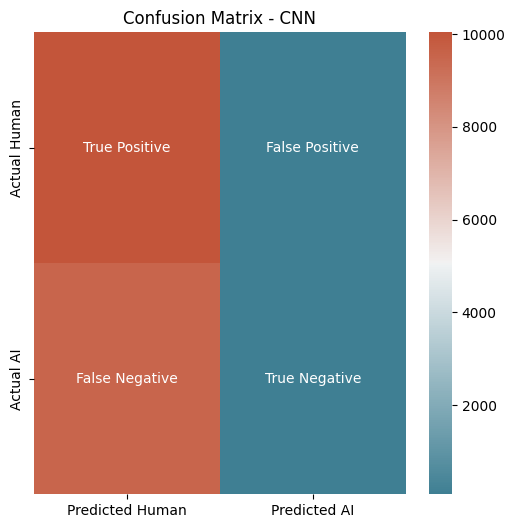

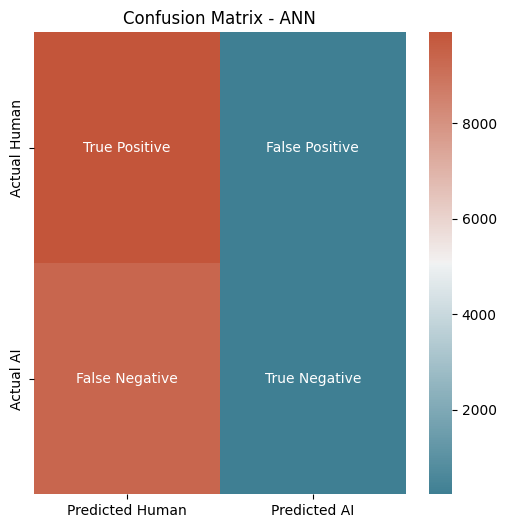

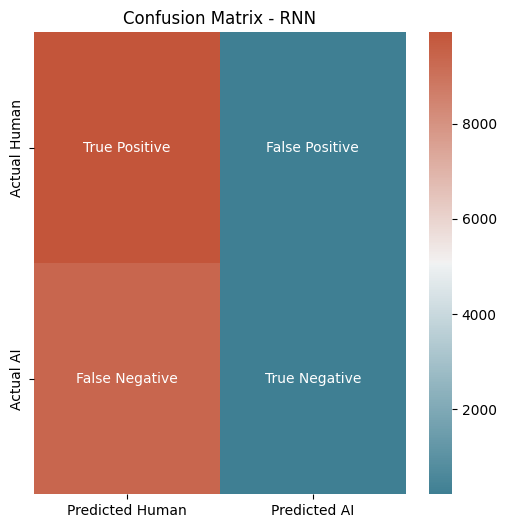

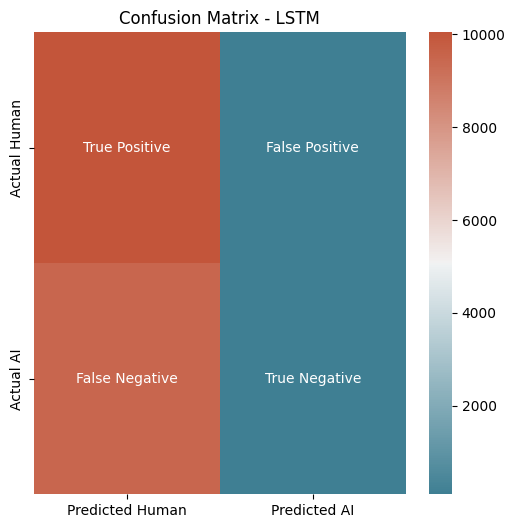

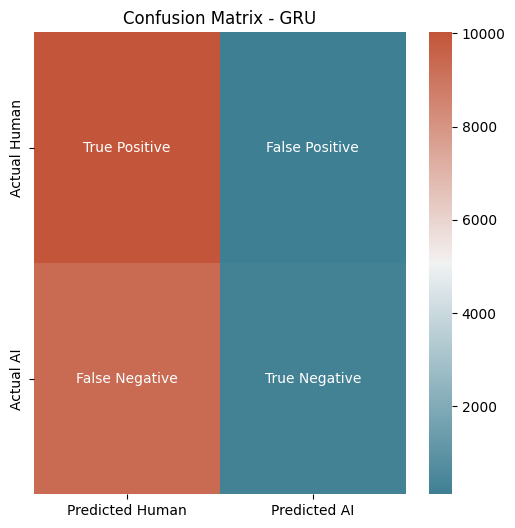

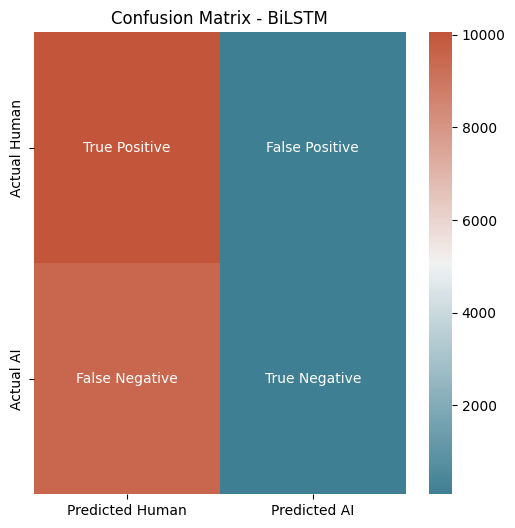

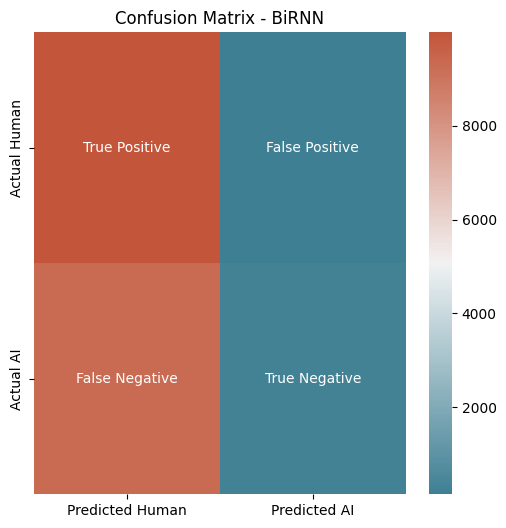

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the data
models = ['CNN', 'ANN', 'RNN', 'LSTM', 'GRU', 'BiLSTM', 'BiRNN']
true_positives = np.array([10041, 9901, 9917, 10041, 10025, 10056, 9995])
false_positives = np.array([93, 233, 217, 93, 109, 78, 139])
true_negatives = np.array([73, 234, 234, 117, 245, 102, 260])
false_negatives = np.array([9516, 9355, 9355, 9472, 9344, 9487, 9329])

# Create confusion matrices
confusion_matrices = [np.array([[tp, fp], [fn, tn]]) for tp, fp, tn, fn in zip(true_positives, false_positives, true_negatives, false_negatives)]

# Define a custom color map that blends blue and yellow
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Define labels for the squares
labels = [['True Positive', 'False Positive'], ['False Negative', 'True Negative']]

# Plot confusion matrices for each model with labels
for i, model in enumerate(models):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrices[i], annot=labels, fmt='', cmap=cmap, xticklabels=['Predicted Human', 'Predicted AI'], yticklabels=['Actual Human', 'Actual AI'])
    plt.title(f'Confusion Matrix - {model}')
    plt.show()
